In [1]:
# 调用相关库
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
from scipy.io import savemat,loadmat
import numpy
import os

In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [4]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [5]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [6]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in *  n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]

# 将数据转换为3D输入，[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1149, 3, 1) (1149, 1) (288, 3, 1) (288, 1)


In [7]:
# 注意力机制
class AttentionLayer(Layer):
    # BahdanauAttention https://blog.csdn.net/u010960155/article/details/82853632
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1],),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):  # 输入：inputs.shape = (batch_size, time_steps, seq_len)
        # Permute将2、1轴翻转后，(batch_size, time_steps, seq_len) -> (batch_size, lstm_units, seq_len)
        # 转换后：x.shape = (batch_size, seq_len, time_steps)
        x = K.permute_dimensions(inputs, (0, 2, 1))

        # 经过一个全连接层和Softmax后，其维度仍为(batch_size, seq_len, time_steps)
        # 其实际内涵为，利用全连接层计算每一个time_steps的权重
        a = K.softmax(K.tanh(K.dot(x, self.W) + self.b))

        # a * x后获得每一个step中，每个维度在所有step中的权重
        # 再经过Permute将2、1轴翻转后，(batch_size, seq_len, time_steps) -> (batch_size, time_steps, seq_len)
        outputs = K.permute_dimensions(a * x, (0, 2, 1))
        outputs = K.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

In [8]:
'''
进行适应度计算,以均方差为适应度函数，目的是找到一组超参数 使得网络的误差最小
'''
#  这里给你优化了学习率和lstm神经元个数两个参数   后期想加可以增加去优化迭代次数，batch_size等参数   ，lstm其他层数的神经元   这里网络是但lstm层   优化的参数越多相对来说算法运行时间越长，也和下边的max_iter和population_size有关
def fitness(pop, P, T, Pt, Tt):
    tf.random.set_seed(0)
    alpha = pop[0]  # 学习率
    hidden_nodes0 = int(pop[1])  # 第一隐含层神经元
    #     num_epochs = int(pop[2])#迭代次数
    #     batch_size = int(pop[3])# batchsize
    #     hidden_nodes = int(pop[4])#第二隐含层神经元

    inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))
    lstm = LSTM(hidden_nodes0, activation='selu', return_sequences=True)(inputs)
    # 注意力机制
    attention = AttentionLayer()(lstm)
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha), loss='mse')
    model.summary()  # 展示模型结构

    model.fit(train_X, train_y, epochs=60, batch_size=30, validation_data=(test_X, test_y), verbose=2,
              shuffle=False)

    # 对测试结果进行反归一化
    test_pred = model.predict(test_X)

    F2 = np.mean(np.square((test_pred-test_y)))

    return F2

In [9]:
def boundary(pop,lb,ub):
    # 防止粒子跳出范围,除学习率之外 其他的都是整数
    pop=[int(pop[i]) if i>0 else pop[i] for i in range(len(lb))]
    for i in range(len(lb)):
        if pop[i]>ub[i] or pop[i]<lb[i]:
            if i==0:
                pop[i] = (ub[i]-lb[i])*np.random.rand()+lb[i]
            else:
                pop[i] = np.random.randint(lb[i],ub[i])
    return pop

def IPSO(train_X, train_Y, valid_X, valid_Y):
    # PSO参数设置
    pN = 5    # pN 最大迭代次数
    max_iter = 10  #pN#max_iter 和pN这两个参数设置的越大,相对来说寻优出来适应度越好效果越好,但是算法运行花的时间就越多   这里给你设置的都很小 ，为了快速跑出结
    #优化了两个参数  学习率和神经元个数   Lb和Ub分别为寻优范围上下限
    # 第一个是学习率[0.001 0.01]
    # 第二个是神经元个数[10-120]
    lb = [0.001,10]
    ub = [0.01,100]#
    dim = len(lb)  # 寻优维度
    
    c1 = 1.5;
    c2 = 1.5;
    r1 = 0.8;
    r2 = 0.3
    wmax = 0.8;
    wmin = 0.6

    # 初始化
    X = np.zeros((pN, dim))
    V = np.zeros((pN, dim))
    pbest = np.zeros((pN, dim))
    gbest = np.zeros((1, dim))
    p_fit = np.zeros(pN)
    result = np.zeros((max_iter, dim))
    fit = np.inf
    for i in range(pN):
        for j in range(dim):
            if j == 0:  # 学习率是小数 其他的是整数
                X[i][j] = (ub[j] - lb[j]) * np.random.rand() + lb[j]
            else:
                X[i][j] = np.random.randint(lb[j], ub[j])
            V[i][j] = np.random.rand()
        pbest[i] = X[i].copy()
        tmp = fitness(X[i, :], train_X, train_Y, valid_X, valid_Y)
        p_fit[i] = tmp
        if (tmp < fit):
            fit = tmp
            gbest = X[i]
            # 开始循环迭代
    trace = []
    for t in range(max_iter):

        w = wmax - (wmax - wmin) * np.tanh(np.pi / 4 * t / max_iter)

        for i in range(pN):
            V[i, :] = w * V[i, :] + c1 * r1 * (pbest[i] - X[i, :]) + c2 * r2 * (gbest - X[i, :])
            X[i, :] = X[i, :] + V[i, :]
            X[i, :] = boundary(X[i, :], lb, ub)  # 边界判断
            # 加入自适应变异操作，避免陷入局部最优
            prob = 0.5 * t / max_iter + 0.5  # 自适应变异，随着进化代数的增加，变异几率越小
            if np.random.rand() > prob:
                for j in range(dim):
                    if j == 0:
                        X[i][j] = (ub[j] - lb[j]) * np.random.rand() + lb[j]
                    else:
                        X[i][j] = np.random.randint(lb[j], ub[j])

        for i in range(pN):  # 更新gbest\pbest
            temp = fitness(X[i, :], train_X, train_Y, valid_X, valid_Y)
            if (temp < p_fit[i]):  # 更新个体最优
                p_fit[i] = temp
                pbest[i, :] = X[i, :]
                if (p_fit[i] < fit):  # 更新全局最优
                    gbest = X[i, :].copy()
                    fit = p_fit[i].copy()
        result[t, :] = gbest.copy()
        trace.append(fit)
        print(t, fit, [int(gbest[i]) if i > 0 else gbest[i] for i in range(len(lb))])
    return trace, gbest, result

In [10]:
trace,best,result=IPSO(train_X,train_y,test_X,test_y)
savemat('结果/IPSO_para.mat',{'trace':trace,'best':best,'result':result})
print("最优学习率、LSTM层神经元的参数分别为：",[int(best[i]) if i>0 else best[i] for i in range(len(best))])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 23)             2300      
                                                                 
 attention_layer (AttentionL  (None, 23)               12        
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 1)                 24        
                                                                 
Total params: 2,336
Trainable params: 2,336
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
39/39 - 3s - loss: 0.3870 - val_loss: 0.0733 - 3s/epoch - 83ms/step
Epoch 2/60
39/39 - 0s - loss: 0.0585 - val_los

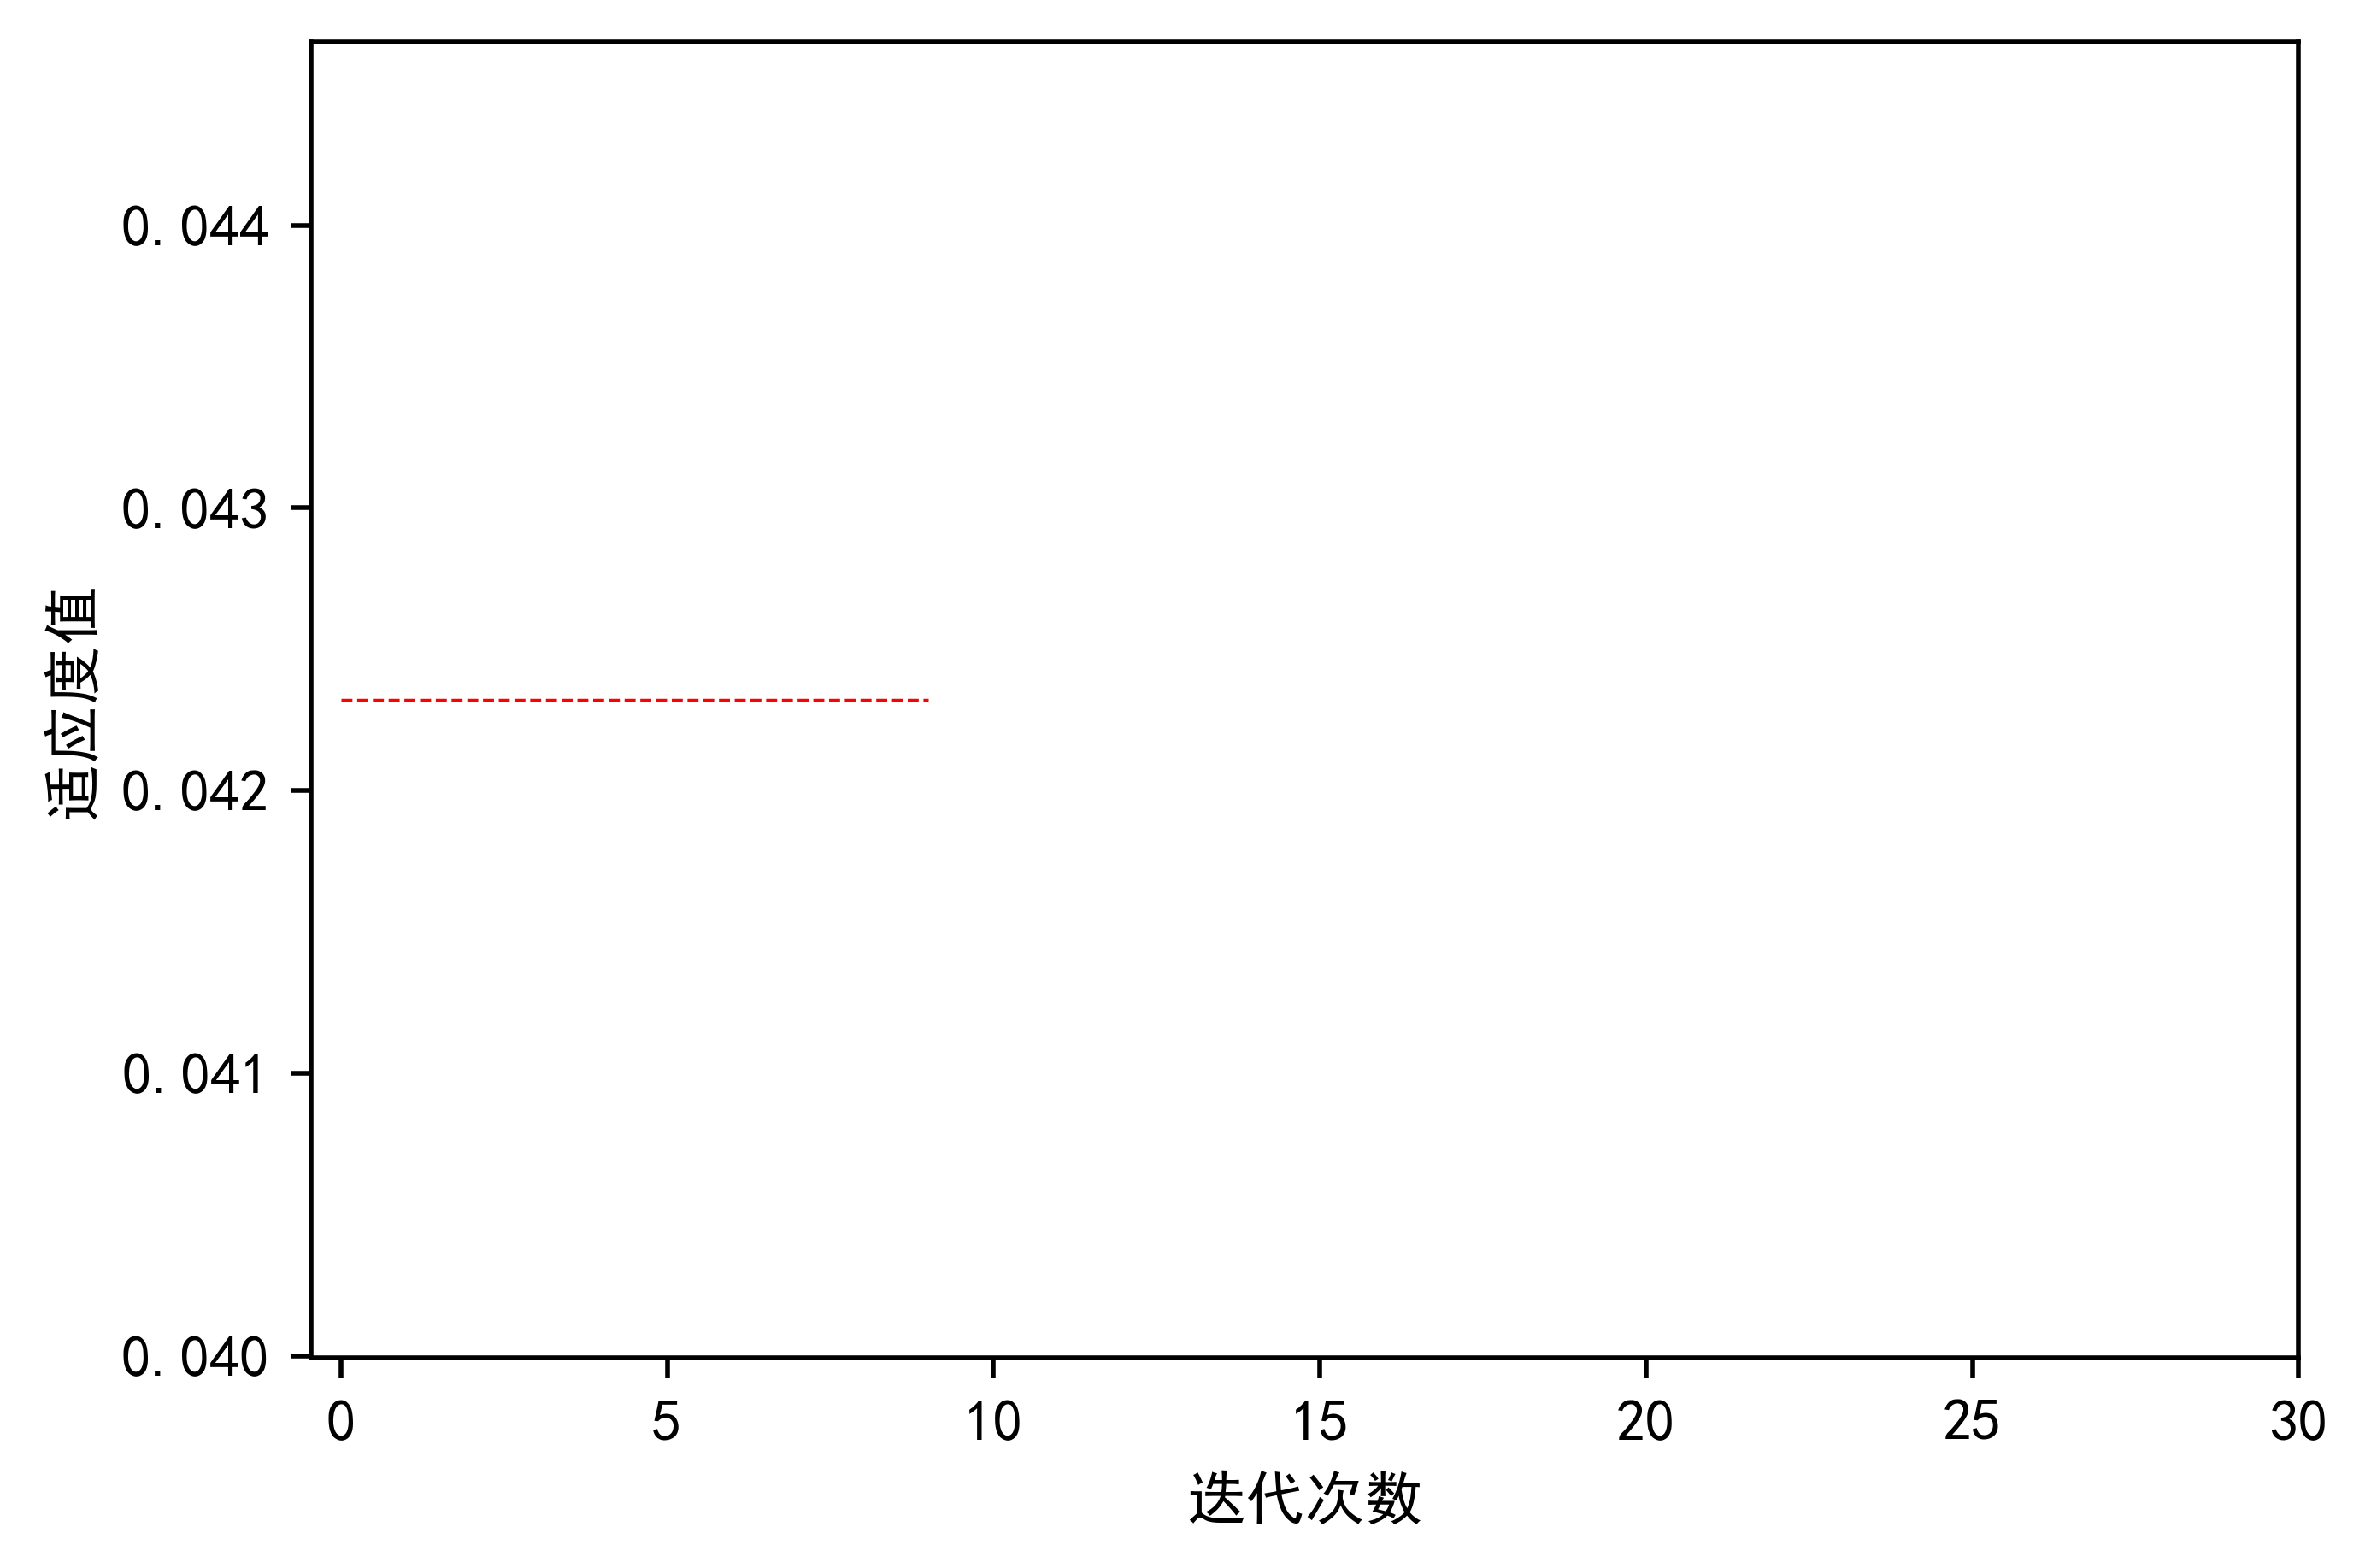

In [11]:
#迭代次数适应度函数曲线
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']   #显示中文
mpl.rcParams['axes.unicode_minus']=False       #显示负号
plt.figure(figsize=(6,4),dpi=500)
plt.plot(trace,'r',linestyle="--",linewidth=0.5)
plt.xticks(list(range(0,31, 5)))
plt.xlabel('迭代次数',fontsize=10)
plt.ylabel('适应度值',fontsize=10)
plt.show()